In [ ]:
# Import necessary libraries and modules needed
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
import numpy as np
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore
import matplotlib.pyplot as plt
from fastapi import FastAPI
from pydantic import BaseModel
import tensorflow as tf
import pickle

In [ ]:
df = pd.read_csv("WELFake_Dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
df.isnull().sum()  # sum of missing values

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [ ]:
df.fillna("", inplace=True)
df.isnull().sum()  # Confirm columns aren't missing again

title    0
text     0
label    0
dtype: int64

In [ ]:
df["content"] = df["title"] + " " + df["text"]  # type: ignore

In [ ]:
X = df["content"].values
y = df["label"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28
)

In [ ]:
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Encode each text input

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_len = 300  # Maximum sequence length
X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding="post")

In [ ]:
# Convert labels to an array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
vocab_size = 50000
embedding_dim = 128
max_len = 300

In [ ]:
model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid"),  # binary classification
    ]
)

c:\Users\HP\projects\fakenews_detector\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,  # Stop if val_loss doesn't improve for 2 epochs
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
    X_train_pad,
    y_train,
    batch_size=64,
    epochs=10,  # Increased epochs; EarlyStopping will stop training early if needed
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 1200s 2s/step - accuracy: 0.9076 - loss: 0.2281 - val_accuracy: 0.9525 - val_loss: 0.1189
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 1244s 2s/step - accuracy: 0.9801 - loss: 0.0614 - val_accuracy: 0.9652 - val_loss: 0.1023
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 1167s 2s/step - accuracy: 0.9896 - loss: 0.0312 - val_accuracy: 0.9634 - val_loss: 0.1316
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 1677s 2s/step - accuracy: 0.9941 - loss: 0.0184 - val_accuracy: 0.9639 - val_loss: 0.1371


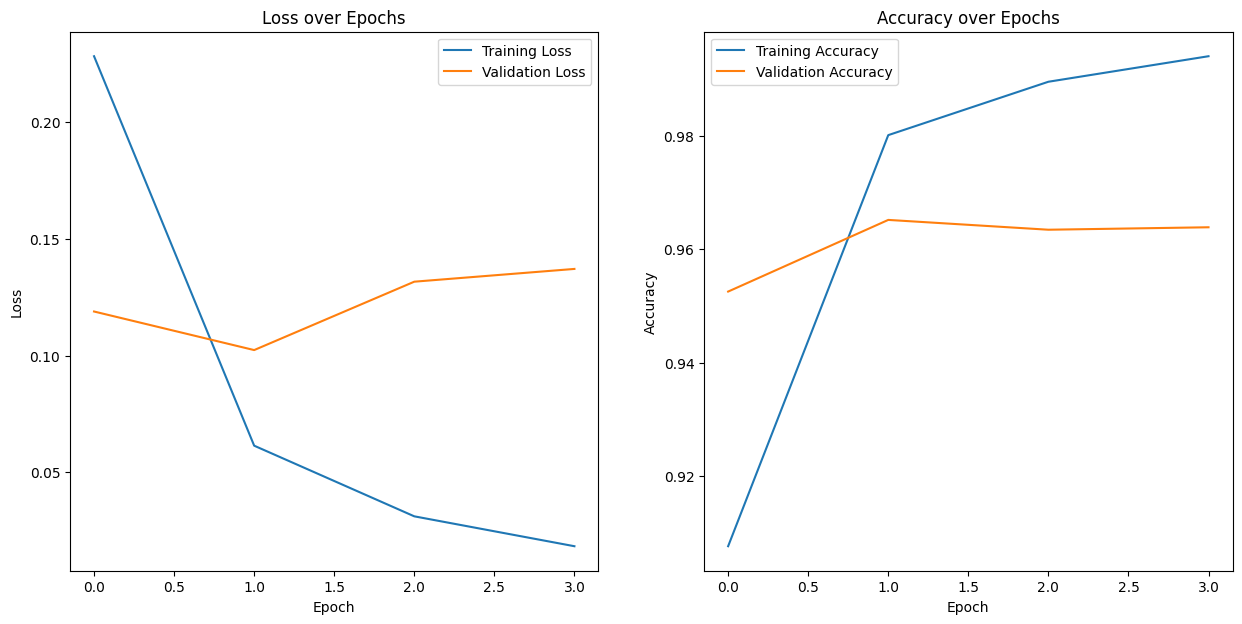

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Accuracy: {acc:.3f} \n Loss: {loss:.4f}")

451/451 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - accuracy: 0.9690 - loss: 0.0938
Accuracy: 0.969 
 Loss: 0.0938


In [ ]:
model.save("fake_news_model.keras")

In [ ]:
app = FastAPI()

In [ ]:
model = tf.keras.models.load_model("fake_news_model.keras")  # type: ignore

In [ ]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [ ]:
max_len = 300

In [ ]:
class NewsItem(BaseModel):
    text: str

In [ ]:
def predict_news(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding="post")
    pred = model.predict(pad)[0][0]
    return "The news provided is Fake" if pred > 0.5 else "The news provided is Real"

In [ ]:
@app.post("/predict")
def predict(item: NewsItem):
    result = predict_news(item.text)
    return {"prediction": result}

In [ ]:
true = pd.read_csv("True.csv")

In [ ]:
fake = pd.read_csv("Fake.csv")

In [ ]:
true["content"] = true["title"] + "" + true["text"]

In [ ]:
fake["content"] = fake["title"] + "" + fake["text"]

In [ ]:
true["content"] = true["title"] + ":" + true["text"]

In [ ]:
fake["content"] = fake["title"] + ":" + fake["text"]

In [ ]:
true.head()

,title,text,subject,date,content
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...


In [ ]:
fake.head(7)

,title,text,subject,date,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Pope Francis Just Called Out Donald Trump Dur...
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",Racist Alabama Cops Brutalize Black Boy While...
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017","Fresh Off The Golf Course, Trump Lashes Out A..."
